In [1]:
# Load data and inspect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from scipy import stats

df = pd.read_csv(r"C:\Users\User\Downloads\lalonde_data(1).csv")

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Getting a general feel for the data and the dataset
print("Dataset shape:", df.shape)
print("\nFirst five rows\n", df.head())

Dataset shape: (614, 11)

First five rows
      ID  treat  age  educ  black  hispan  married  nodegree  re74  re75  \
0  NSW1      1   37    11      1       0        1         1   0.0   0.0   
1  NSW2      1   22     9      0       1        0         1   0.0   0.0   
2  NSW3      1   30    12      1       0        0         0   0.0   0.0   
3  NSW4      1   27    11      1       0        0         1   0.0   0.0   
4  NSW5      1   33     8      1       0        0         1   0.0   0.0   

         re78  
0   9930.0460  
1   3595.8940  
2  24909.4500  
3   7506.1460  
4    289.7899  


In [3]:
# Getting general statistics for the dataset as a whole to familiarize myself with it
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
# Getting the necessary Descritpive statistics by group
df.groupby("treat")[["age","educ","black","hispan","married",
                    "nodegree","re74","re75","re78"]].agg(["mean","std"])


age                  educ               black            \
            mean        std       mean       std      mean       std   
treat                                                                  
0      28.030303  10.786653  10.235431  2.855238  0.202797  0.402552   
1      25.816216   7.155019  10.345946  2.010650  0.843243  0.364558   

         hispan             married            nodegree            \
           mean       std      mean       std      mean       std   
treat                                                               
0      0.142191  0.349654  0.512821  0.500419  0.596737  0.491126   
1      0.059459  0.237124  0.189189  0.392722  0.708108  0.455867   

              re74                      re75                      re78  \
              mean          std         mean          std         mean   
treat                                                                    
0      5619.236506  6788.750796  2466.484443  3291.996183  6984.169742   
1      2095.573689  4886.620353  1532.055314  3219.250870  6349.143530   

                    
               std  
treat               
0      7294.161791  
1      7867.402218

### No missing values in the dataset, good. Big difference in mean income of two groups -> BAD

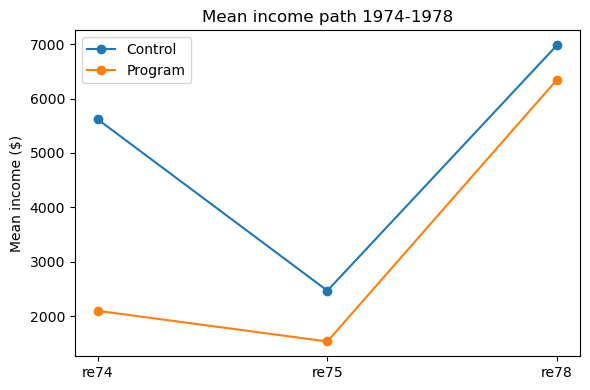

In [5]:
# Plotting the mean income by group
mean_paths = (
    df
    .melt(id_vars=['treat'], value_vars=['re74','re75','re78'],
          var_name='year', value_name='income')
    .groupby(['treat','year'])['income'].mean()
    .unstack(0)
    .rename(columns={0:'Control',1:'Program'})
)

plt.figure(figsize=(6,4))
for col in mean_paths.columns:
    plt.plot(mean_paths.index, mean_paths[col], marker='o', label=col)
plt.ylabel("Mean income ($)")
plt.title("Mean income path 1974‑1978")
plt.legend()
plt.tight_layout()
plt.show()


## It appears that the two groups could very well be violating the assumptions that they are identical in characteristics and that their trends are identical too (1974-> 1975 much bigger drop for control income). Could provide issue in DiD due to different trends and the difference in characteristics could threaten the accuracy of the whole analysis

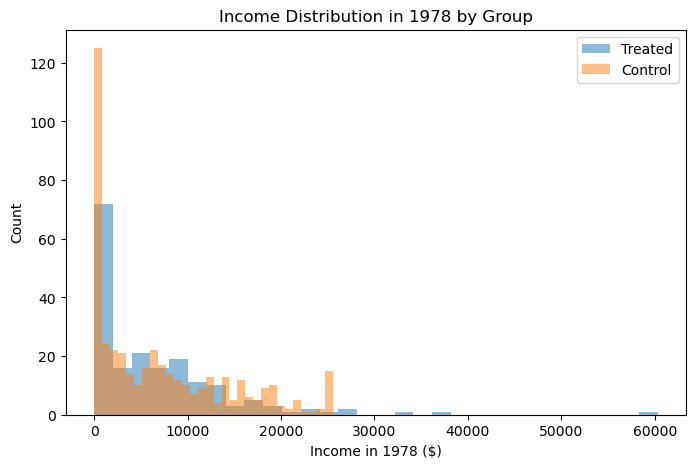

In [6]:
# Distribution of income between groups
# Histogram of income distribution in 1978
plt.figure(figsize=(8, 5))
plt.hist(df.loc[df['treat'] == 1, 're78'], bins=30, alpha=0.5, label='Treated')
plt.hist(df.loc[df['treat'] == 0, 're78'], bins=30, alpha=0.5, label='Control')
plt.xlabel('Income in 1978 ($)')
plt.ylabel('Count')
plt.title('Income Distribution in 1978 by Group')
plt.legend()
plt.show()


### Distribution is highly concentrated at 0.
### Will not drop, as there likely exists meaning behind those 0 and thus dropping them will introduce bias and also lessen the No. of Observations

## It appears we have heteroskedasticity. Need to account for it in my regressions

In [7]:
# Ορισμός του μοντέλου OLS με όλους τους ελεγκτές και heteroskedasticity robust SE
import statsmodels.formula.api as smf
ols_model = smf.ols('re78 ~ treat + age + educ + black + hispan + married + nodegree + re74 + re75', data=df
                   ).fit(cov_type="HC3")
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     9.483
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           1.42e-13
Time:                        13:10:49   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.5145   2570.295      0.026      0.9

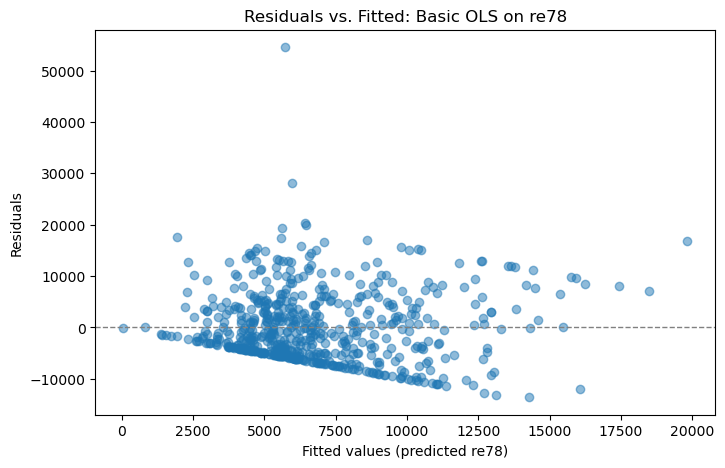

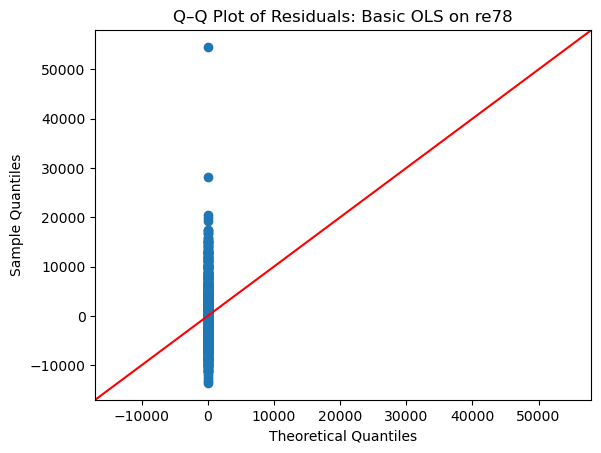

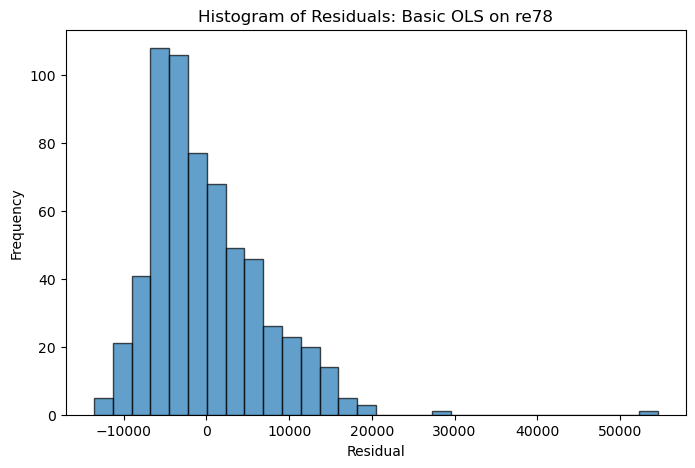

In [8]:
# Residuals vs. Fitted for basic OLS on re78
models = {
    "Basic OLS on re78": ols_model
}

for name, model in models.items():
    fitted = model.fittedvalues
    resid  = model.resid

    # 1) Residuals vs Fitted
    plt.figure(figsize=(8, 5))
    plt.scatter(fitted, resid, alpha=0.5)
    plt.axhline(0, linestyle='--', linewidth=1, color='grey')
    plt.xlabel('Fitted values (predicted re78)')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted: {name}')
    plt.show()

    # 2) Q–Q Plot
    sm.qqplot(resid, line='45')
    plt.title(f'Q–Q Plot of Residuals: {name}')
    plt.show()

    # 3) Histogram of Residuals
    plt.figure(figsize=(8, 5))
    plt.hist(resid, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals: {name}')
    plt.show()

In [9]:
# Will be introducing some non-linear variables to check linearity assumption
df['age_sq'] = df['age'] ** 2
df['educ_sq'] = df['educ'] ** 2

# Will also introduce log version of re74, re75, re78
df['log_re74'] = np.log(df['re74'].clip(lower=1))
df['log_re75'] = np.log(df['re75'].clip(lower=1))
df['log_re78'] = np.log(df['re78'].clip(lower=1))


In [10]:
#I will be OLS regressing re78 on all variables including the non linear age and educ
ols_non_linear = smf.ols('re78 ~ treat + age + educ + black + hispan + married + nodegree + re74 + re75 + educ_sq + age_sq', data=df
                        ).fit(cov_type="HC3")
print(ols_non_linear.summary())


                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     8.411
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           7.38e-14
Time:                        13:10:50   Log-Likelihood:                -6295.9
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     602   BIC:                         1.267e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    789.3808   4321.970      0.183      0.8

### Not much difference in results. Seems like linearity isn't a problematic assumption. Can't solve for any bias due to missing variables that should be in regression IF such bias exists.

In [11]:
# I will be OLS regressing log_re78 on all variables including the non linear age and educ
ols_log = smf.ols('log_re78 ~ treat + age + educ + black + hispan + married + nodegree + log_re74 + log_re75 + educ_sq + age_sq', data=df
                        ).fit(cov_type="HC3")
print(ols_log.summary())


                            OLS Regression Results                            
Dep. Variable:               log_re78   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.945
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           1.49e-05
Time:                        13:10:50   Log-Likelihood:                -1667.3
No. Observations:                 614   AIC:                             3359.
Df Residuals:                     602   BIC:                             3412.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7621      2.297      1.203      0.2

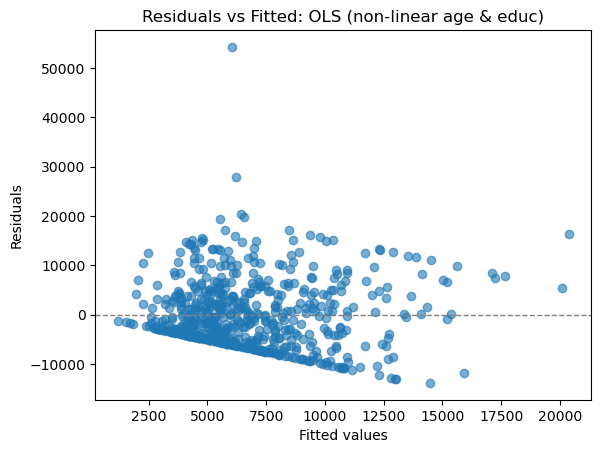

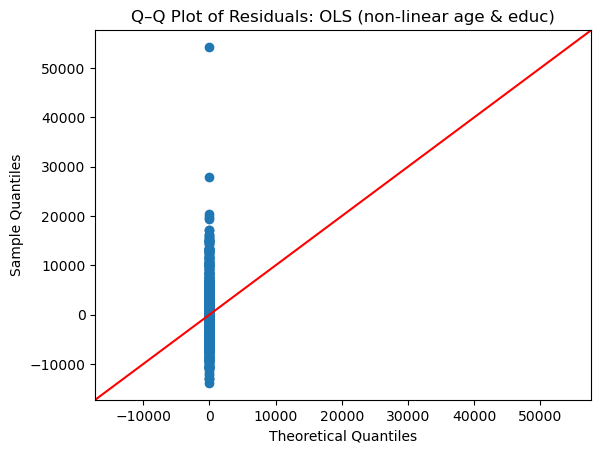

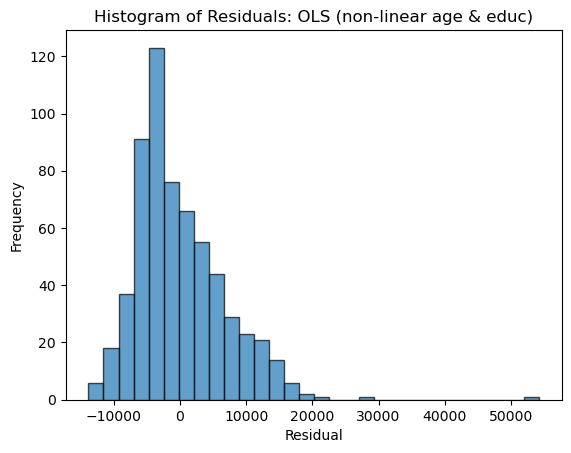

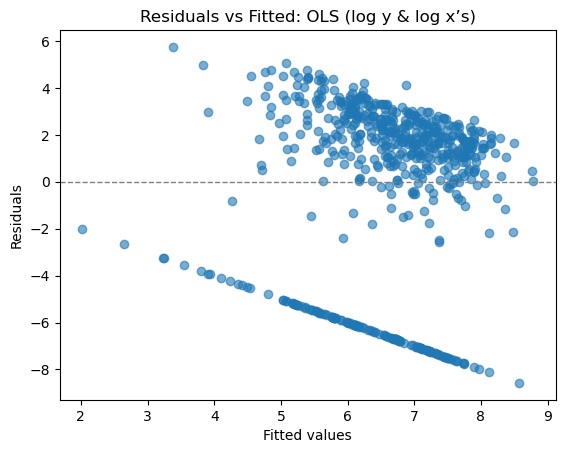

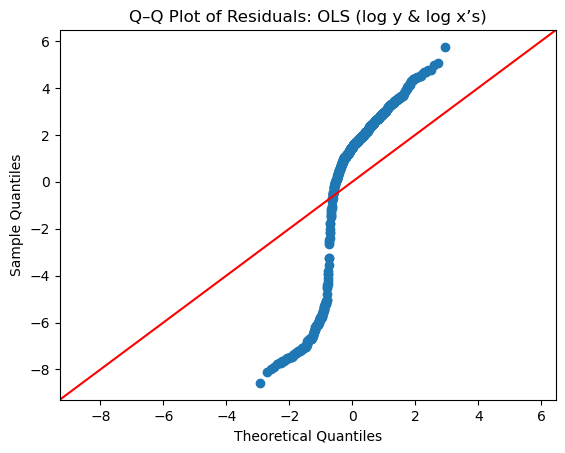

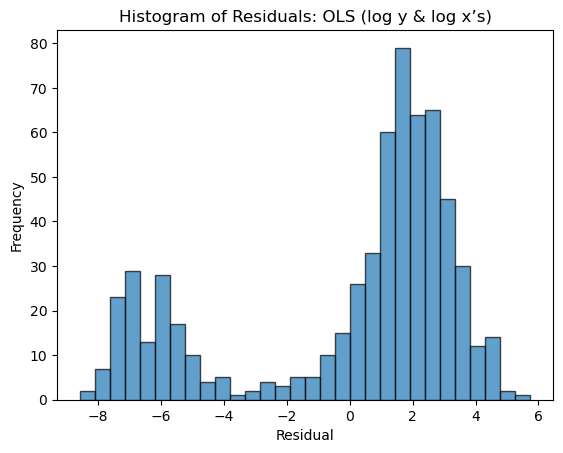

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Put the two models into a dict
models = {
    "OLS (non‐linear age & educ)": ols_non_linear,
    "OLS (log y & log x’s)":       ols_log
}

for name, model in models.items():
    resid  = model.resid
    fitted = model.fittedvalues

    # 1) Residuals vs Fitted
    plt.figure()
    plt.scatter(fitted, resid, alpha=0.6)
    plt.axhline(0, linestyle="--", linewidth=1, color="grey")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted: {name}")
    plt.show()

    # 2) Q–Q Plot
    sm.qqplot(resid, line="45")
    plt.title(f"Q–Q Plot of Residuals: {name}")
    plt.show()

    # 3) Histogram of Residuals
    plt.figure()
    plt.hist(resid, bins=30, edgecolor="k", alpha=0.7)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Residuals: {name}")
    plt.show()


### Seems like log regression is not the correct way to analyse the above data, as, R_sq dropped and also statistically signigicant values such as Treat are no longer statistically significant.

### Now I will use Differences in Differences

#### Panel Data

In [13]:
# Reshape to long format: one row per person‐period
df_long = df.melt(
    id_vars=["ID","treat","age","educ","black","hispan","married","nodegree"],
    value_vars=["re75","re78"],
    var_name="period", value_name="earn"
)
# Indicator for post‐treatment period (1978)
df_long["post"] = (df_long["period"] == "re78").astype(int)

# Interaction term: treat × post
df_long["treat_post"] = df_long["treat"] * df_long["post"]

did_panel = smf.ols(
    "earn ~ treat + post + treat_post + age + educ + black + hispan + married + nodegree",
    data=df_long
).fit(cov_type="cluster", cov_kwds={"groups": df_long["ID"]})
print("==================Panel Data================")
print(did_panel.summary())


==================Panel Data================
                            OLS Regression Results                            
Dep. Variable:                   earn   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     31.80
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           8.36e-46
Time:                        13:10:51   Log-Likelihood:                -12335.
No. Observations:                1228   AIC:                         2.469e+04
Df Residuals:                    1218   BIC:                         2.474e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

In [14]:
# For some reason the code wouldn't run if I didn't include the precess of getting the squared values again
df_long["age_sq"] = df_long["age"] ** 2
df_long["educ_sq"] = df_long["educ"] ** 2

# Panel Data Regression with Squared Terms to check if they help in the estimation of interaction term.
did_panel_sq = smf.ols(
    "earn ~ treat + post + treat_post + age + educ + black + hispan + married + nodegree + age_sq + educ_sq",
    data=df_long
).fit(cov_type="cluster", cov_kwds={"groups": df_long["ID"]})
print("================Panel Data with squared terms====================")
print(did_panel_sq.summary())


================Panel Data with squared terms====================
                            OLS Regression Results                            
Dep. Variable:                   earn   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     26.45
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           3.90e-45
Time:                        13:10:51   Log-Likelihood:                -12329.
No. Observations:                1228   AIC:                         2.468e+04
Df Residuals:                    1216   BIC:                         2.474e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

### Square terms again seem to not change much of the outcome of the regression, although one big change was that age became statistically significant and education statistically insignificant (the reverse was the case before)

#### What this method offers me: 1) explicitly controls for observed covariates 2) clusters SEs.
#### What this method has as a limitation: still vulnerable to any unobserved, time-invariant bias

### Finally, I will be using FE Panel Data Analysis performing DiD

In [15]:
# Fixed Effect Panel Data Analysis
did_fe = smf.ols(
    "earn ~ treat_post + C(ID) + C(period)",
    data=df_long
).fit(cov_type="cluster", cov_kwds={"groups": df_long["ID"]})

# Point‐estimate DiD (treat_post) coefficient
coef = did_fe.params["treat_post"]

# Cluster‐robust standard error for that coefficient
se   = did_fe.bse["treat_post"]

# t‐value and p‐value
tval = did_fe.tvalues["treat_post"]
pval = did_fe.pvalues["treat_post"]

# 95% confidence interval
ci_lower, ci_upper = did_fe.conf_int().loc["treat_post"]

# Goodness‐of‐fit
r2    = did_fe.rsquared
adj_r2 = did_fe.rsquared_adj

print("================Panel Data FE Outcome for interaction term===============")
print(f"DiD estimate = {coef:.2f}  (SE = {se:.2f},  t = {tval:.2f},  p = {pval:.3f})")
print(f"95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"R² = {r2:.3f},  adj-R² = {adj_r2:.3f}")


================Panel Data FE Outcome for interaction term===============
DiD estimate = 299.40  (SE = 981.24,  t = 0.31,  p = 0.760)
95% CI = [-1623.80, 2222.60]
R² = 0.651,  adj-R² = 0.300


### Better R_squared than before! The coefficient is the same but, higher SE and p-value. Higher R_squared likely points to the fact that we have at least a few missing variables necessary but unaccounted in out Panel Data Regression.
### Not much I can do about it since this is likely a limitation of the data

#### Why I used this method: 1) absorbs all time-invariant confounders 2) clusters SEs so the two observations per person are handled correctly

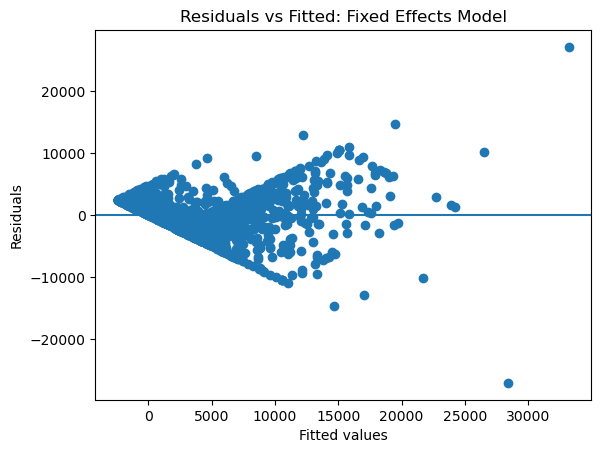

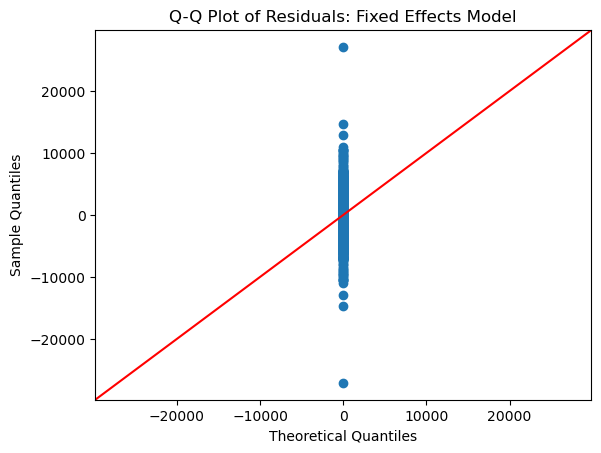

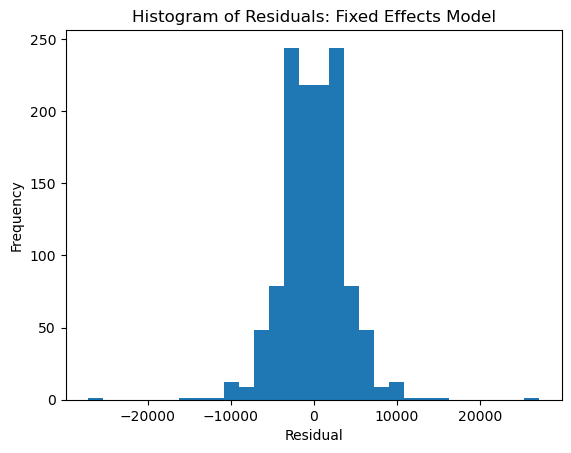

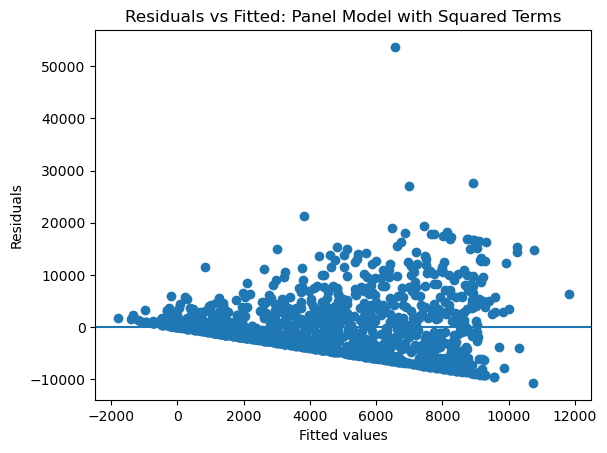

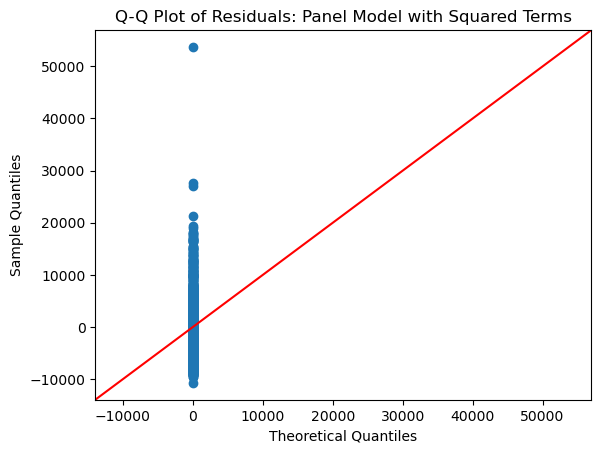

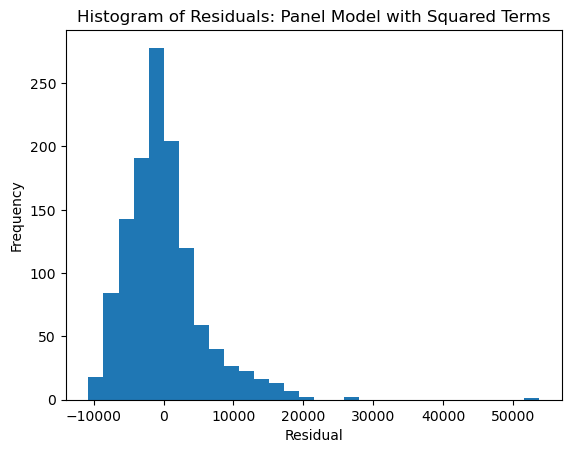

In [16]:
# Assuming `did_fe` and `did_panel_sq` are statsmodels RegressionResults objects
models = {
    "Fixed Effects Model": did_fe,
    "Panel Model with Squared Terms": did_panel_sq
}

for name, model in models.items():
    resid = model.resid
    fitted = model.fittedvalues

    # Residuals vs Fitted Values
    plt.figure()
    plt.scatter(fitted, resid)
    plt.axhline(0)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted: {name}")
    plt.show()

    # Q-Q Plot
    sm.qqplot(resid, line="45")
    plt.title(f"Q-Q Plot of Residuals: {name}")
    plt.show()

    # Histogram of Residuals
    plt.figure()
    plt.hist(resid, bins=30)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Residuals: {name}")
    plt.show()
